# Multivariate Timeseries Forecasting of Dengue Cases  

# Initial Data Examination and Preliminary Cleaning  

## Data Origins and General Description  

The data was obtained from Driven Data:  

https://www.drivendata.org/competitions/44/dengai-predicting-disease-spread/  

It is comprised of timestamped environmental measurements suspected to have bearing on confirmed dengue cases in two cities:  San Juan, Puerto Rico and Iquitos, Peru.  The labels - number of dengue cases, also timestamped - are also provided for supervised learning approaches.  

The features are as listed:  

##### City and date indicators 
* city – City abbreviations: sj for San Juan and iq for Iquitos  
*  week_start_date – Date given in yyyy-mm-dd format  

##### NOAA's GHCN daily climate data weather station measurements  
* station_max_temp_c – Maximum temperature  
* station_min_temp_c – Minimum temperature  
* station_avg_temp_c – Average temperature  
* station_precip_mm – Total precipitation  
* station_diur_temp_rng_c – Diurnal temperature range  

For further reading:  https://www.ncei.noaa.gov/products/land-based-station/global-historical-climatology-network-daily

##### PERSIANN satellite precipitation measurements (0.25x0.25 degree scale)  
* precipitation_amt_mm – Total precipitation   

##### NOAA's NCEP Climate Forecast System Reanalysis measurements (0.5x0.5 degree scale)  
* reanalysis_sat_precip_amt_mm – Total precipitation  
* reanalysis_dew_point_temp_k – Mean dew point temperature  
* reanalysis_air_temp_k – Mean air temperature  
* reanalysis_relative_humidity_percent – Mean relative humidity  
* reanalysis_specific_humidity_g_per_kg – Mean specific humidity  
* reanalysis_precip_amt_kg_per_m2 – Total precipitation  
* reanalysis_max_air_temp_k – Maximum air temperature  
* reanalysis_min_air_temp_k – Minimum air temperature  
* reanalysis_avg_temp_k – Average air temperature  
* reanalysis_tdtr_k – Diurnal temperature range  

For further reading:  https://www.nccs.nasa.gov/services/data-collections/coupled-products/cfsr#:~:text=The%20National%20Oceanic%20and%20Atmospheric,period%20(1979%2D2009).

##### Satellite vegetation - Normalized difference vegetation index (NDVI) - NOAA's CDR Normalized Difference Vegetation Index (0.5x0.5 degree scale) measurements  
* ndvi_se – Pixel southeast of city centroid  
* ndvi_sw – Pixel southwest of city centroid  
* ndvi_ne – Pixel northeast of city centroid  
* ndvi_nw – Pixel northwest of city centroid  

For an explanation of NDVI:  
Wikipedia:  "It has a high correlation with the true state of vegetation on the ground. The index is easy to interpret: NDVI will be a value between -1 and 1. An area with nothing growing in it will have an NDVI of zero. NDVI will increase in proportion to vegetation growth. An area with dense, healthy vegetation will have an NDVI of one. NDVI values less than 0 suggest a lack of dry land. An ocean will yield an NDVI of -1."  
https://en.wikipedia.org/wiki/Normalized_difference_vegetation_index, accessed Feb 2 2024

## Data: Behavioural Characteristics Driving the Analysis

When the timestamped dengue cases are examined on their own, the process is a univariate timeseries forecasting exercise.  This only examines how previous dengue cases impact feature dengue cases to help identify if the output or dependent variable is autocorrelated.  To do this an autoregression (regressing against the same variable) is performed.

When the environmental measurements are included, it becomes a multivariate forecasting exercise.  In these scenarios, not only is autocorrelation of the dependent or predicted variable examined, but its correlation to the features, or time-lagged features, is also examined.  This is to establish whether a causal relationship between the features and predicted variable exists, and over what time lag.  There exists many model frameworks to enable this sort of analysis.

This notebook contains the steps to import the data, examine basic plots of the data and get a general description of its characteristics, then gather more details around the data's temporal characteristics with the use of lag-plots and autocorrelations.

## Import and Overview of Data Quality  

The data are supplied as a set of training features, which is comprised of the environmental measurements, and training labels, which is simply the number of known dengue cases for each corresponding date.  The data is examined for its overall general characteristics like data type, mean, range, and for any anomalies as well as missing or duplicated data.

In [60]:
import os
import pandas as pd
from matplotlib import pyplot as plt
#import matplotlib.pyplot as plt

In [131]:
# setting up the file path structure
data_folder = os.path.join(os.pardir, 'data')
files_in_data = os.listdir(data_folder)
print(files_in_data)

['dengue_features_test.csv', 'dengue_features_train.csv', 'dengue_labels_train.csv']


# ?Not sure why we're bothering with multiindex  
Causes trouble later when checking for the huge time interval (city change in the rows).

In [132]:
# setting index_col sets up a multi-level index
file_path1 = os.path.join(data_folder, 'dengue_features_train.csv')
train_features = pd.read_csv(file_path1, index_col=[0,1,2])

file_path2 = os.path.join(data_folder, 'dengue_labels_train.csv')
train_labels = pd.read_csv(file_path2, index_col=[0,1,2])

Let's get a sense of the size of the dataset.

In [48]:
print(train_features.shape)
print(train_labels.shape)

(1456, 22)
(1456, 1)


In [8]:
train_features.head()

week_start_date   ndvi_ne   ndvi_nw   ndvi_se   ndvi_sw  \
city year weekofyear                                                           
sj   1990 18              1990-04-30  0.122600  0.103725  0.198483  0.177617   
          19              1990-05-07  0.169900  0.142175  0.162357  0.155486   
          20              1990-05-14  0.032250  0.172967  0.157200  0.170843   
          21              1990-05-21  0.128633  0.245067  0.227557  0.235886   
          22              1990-05-28  0.196200  0.262200  0.251200  0.247340   

                      precipitation_amt_mm  reanalysis_air_temp_k  \
city year weekofyear                                                
sj   1990 18                         12.42             297.572857   
          19                         22.82             298.211429   
          20                         34.54             298.781429   
          21                         15.36             298.987143   
          22                          7.52             299.518571   

                      reanalysis_avg_temp_k  reanalysis_dew_point_temp_k  \
city year weekofyear                                                       
sj   1990 18                     297.742857                   292.414286   
          19                     298.442857                   293.951429   
          20                     298.878571                   295.434286   
          21                     299.228571                   295.310000   
          22                     299.664286                   295.821429   

                      reanalysis_max_air_temp_k  ...  \
city year weekofyear                             ...   
sj   1990 18                              299.8  ...   
          19                              300.9  ...   
          20                              300.5  ...   
          21                              301.4  ...   
          22                              301.9  ...   

                      reanalysis_precip_amt_kg_per_m2  \
city year weekofyear                                    
sj   1990 18                                    32.00   
          19                                    17.94   
          20                                    26.10   
          21                                    13.90   
          22                                    12.20   

                      reanalysis_relative_humidity_percent  \
city year weekofyear                                         
sj   1990 18                                     73.365714   
          19                                     77.368571   
          20                                     82.052857   
          21                                     80.337143   
          22                                     80.460000   

                      reanalysis_sat_precip_amt_mm  \
city year weekofyear                                 
sj   1990 18                                 12.42   
          19                                 22.82   
          20                                 34.54   
          21                                 15.36   
          22                                  7.52   

                      reanalysis_specific_humidity_g_per_kg  \
city year weekofyear                                          
sj   1990 18                                      14.012857   
          19                                      15.372857   
          20                                      16.848571   
          21                                      16.672857   
          22                                      17.210000   

                      reanalysis_tdtr_k  station_avg_temp_c  \
city year weekofyear                                          
sj   1990 18                   2.628571           25.442857   
          19                   2.371429           26.714286   
          20                   2.300000           26.714286   
          21                   2.428571           27.471429   
          22    

In [9]:
train_labels.head()

total_cases
city year weekofyear             
sj   1990 18                    4
          19                    5
          20                    4
          21                    3
          22                    6

Below are some quick statistics on each features, and below that, the statistics on the total cases we're aiming to predict.  
Range on the features can help indicate if some min-max scaling might be required.  The difference in magnitudes seen below indicate this will be required.

In [10]:
train_features.describe()

,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
count,1262.000000,1404.000000,1434.000000,1434.000000,1443.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1443.000000,1446.000000,1446.000000,1413.000000,1413.000000,1436.000000,1442.000000,1434.000000
mean,0.142294,0.130553,0.203783,0.202305,45.760388,298.701852,299.225578,295.246356,303.427109,295.719156,40.151819,82.161959,45.760388,16.746427,4.903754,27.185783,8.059328,32.452437,22.102150,39.326360
std,0.140531,0.119999,0.073860,0.083903,43.715537,1.362420,1.261715,1.527810,3.234601,2.565364,43.434399,7.153897,43.715537,1.542494,3.546445,1.292347,2.128568,1.959318,1.574066,47.455314
min,-0.406250,-0.456100,-0.015533,-0.063457,0.000000,294.635714,294.892857,289.642857,297.800000,286.900000,0.000000,57.787143,0.000000,11.715714,1.357143,21.400000,4.528571,26.700000,14.700000,0.000000
25%,0.044950,0.049217,0.155087,0.144209,9.800000,297.658929,298.257143,294.118929,301.000000,293.900000,13.055000,77.177143,9.800000,15.557143,2.328571,26.300000,6.514286,31.100000,21.100000,8.700000
50%,0.128817,0.121429,0.196050,0.189450,38.340000,298.646429,299.289286,295.640714,302.400000,296.200000,27.245000,80.301429,38.340000,17.087143,2.857143,27.414286,7.300000,32.800000,22.200000,23.850000
75%,0.248483,0.216600,0.248846,0.246982,70.235000,299.833571,300.207143,296.460000,305.500000,297.900000,52.200000,86.357857,70.235000,17.978214,7.625000,28.157143,9.566667,33.900000,23.300000,53.900000
max,0.508357,0.454429,0.538314,0.546017,390.600000,302.200000,302.928571,298.450000,314.000000,299.900000,570.500000,98.610000,390.600000,20.461429,16.028571,30.800000,15.800000,42.200000,25.600000,543.300000


In [11]:
train_labels.describe()

,total_cases
count,1456.000000
mean,24.675137
std,43.596000
min,0.000000
25%,5.000000
50%,12.000000
75%,28.000000
max,461.000000


`.info()` gives a quick idea of the datatypes, but also overall "type of information" gathered.  This dataset is entirely numerical except for the week_start_date column, which is likely string given the ojbect datatype.  Manipulations on week_start_date will require turning this into a datetime.

In [17]:
train_features.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1456 entries, ('sj', 1990, 18) to ('iq', 2010, 25)
Data columns (total 21 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   week_start_date                        1456 non-null   object 
 1   ndvi_ne                                1262 non-null   float64
 2   ndvi_nw                                1404 non-null   float64
 3   ndvi_se                                1434 non-null   float64
 4   ndvi_sw                                1434 non-null   float64
 5   precipitation_amt_mm                   1443 non-null   float64
 6   reanalysis_air_temp_k                  1446 non-null   float64
 7   reanalysis_avg_temp_k                  1446 non-null   float64
 8   reanalysis_dew_point_temp_k            1446 non-null   float64
 9   reanalysis_max_air_temp_k              1446 non-null   float64
 10  reanalysis_min_air_temp_k              1446 n

The dengue case count is naturally an integer datatype.

In [18]:
train_labels.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1456 entries, ('sj', 1990, 18) to ('iq', 2010, 25)
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   total_cases  1456 non-null   int64
dtypes: int64(1)
memory usage: 19.1+ KB


Ensure that the time interval between rows is constant, eg. one week.  If not, rows either have to be dropped or data imputed (interpolated) to maintain a constant time interval.

In [133]:
train_features['week_start_date'] = pd.to_datetime(train_features['week_start_date'])

# Calculate the time difference between consecutive rows
train_features['time_interval'] = train_features['week_start_date'].diff()

# Check if the time interval is constant or changing
is_constant_interval = train_features['time_interval'].nunique() == 1

if is_constant_interval:
    constant_interval = train_features['time_interval'].iloc[0]
    print(f'Time interval is constant: {constant_interval}')
else:
    print('Time interval is changing.')
    unique_intervals = train_features['time_interval'].unique()
    print(f'Unique time intervals: {unique_intervals}')

    # Value counts for each unique time interval
    interval_counts = train_features['time_interval'].value_counts()
    print('Time interval value counts:')
    print(interval_counts)

# Optional: Print the DataFrame with the new 'time_interval' column
#train_features.head()


Time interval is changing.
Unique time intervals: <TimedeltaArray>
[NaT, '7 days', '8 days', '9 days', '-2852 days']
Length: 5, dtype: timedelta64[ns]
Time interval value counts:
time_interval
7 days        1426
8 days          21
9 days           7
-2852 days       1
Name: count, dtype: int64


Most intervals are 7 days, with only a few at 8 and 9 days.  For the purposes of modelling timeseries data, and given we're likely looking at time lags of weeks, not days, this variation in time interval will be considered to have negligible impact.

The interval of -2852 days is likely when the rows of data change from one city to the other.  Let's check.

Turns out a multi-index is a special pain.

In [81]:
train_features[train_features['time_interval']=='-2852 days']

,,,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,time_interval
city,year,weekofyear,,,,,,,,,,,,,,,,,,,,,
iq,2000,26,2000-07-01,0.192886,0.132257,0.340886,0.2472,25.41,296.74,298.45,295.184286,307.3,...,92.418571,25.41,16.651429,8.928571,26.4,10.775,32.5,20.7,3.0,-2852 days


In [82]:
desired_value = '-2852 days'
row_indices = train_features.index[train_features['time_interval'] == desired_value].tolist()

print("Row Indices:", row_indices)

Row Indices: [('iq', 2000, 26)]


In [83]:
# Specify the row you are interested in
desired_row = ('iq', 2000, 26)

# Find the numeric index of the specified row
row_index = train_features.index.get_loc(desired_row)

# Get the preceding row using iloc
preceding_row_index = row_index - 1
preceding_row = train_features.iloc[preceding_row_index]

# Get the multi-index values of the preceding row
preceding_row_values = preceding_row.name

print("Multi-Index Values of the Preceding Row:", preceding_row_values)

Multi-Index Values of the Preceding Row: ('sj', 2008, 17)


The city code changes from iq to sj when the large negative time interval occurs.  This confirms that the enormous negative interval is simply the switch of cities in the data.   

Let's investigate for nulls (NaN) and duplicates.

In [ ]:
train_features.duplicated().sum()

0

In [50]:
train_features.isnull().sum()

week_start_date                            0
ndvi_ne                                  194
ndvi_nw                                   52
ndvi_se                                   22
ndvi_sw                                   22
precipitation_amt_mm                      13
reanalysis_air_temp_k                     10
reanalysis_avg_temp_k                     10
reanalysis_dew_point_temp_k               10
reanalysis_max_air_temp_k                 10
reanalysis_min_air_temp_k                 10
reanalysis_precip_amt_kg_per_m2           10
reanalysis_relative_humidity_percent      10
reanalysis_sat_precip_amt_mm              13
reanalysis_specific_humidity_g_per_kg     10
reanalysis_tdtr_k                         10
station_avg_temp_c                        43
station_diur_temp_rng_c                   43
station_max_temp_c                        20
station_min_temp_c                        14
station_precip_mm                         22
time_interval                              1
dtype: int

In [51]:
train_labels.isnull().sum()

total_cases    0
dtype: int64

There are no duplicates in the features.  

There are no nulls in the training labels, but there are varying amounts of nulls in the features.  For now those missing values will simply be imputed using the last value recorded, but there is room here for more sophisticated approaches.

# ! Revisit imputation

In [134]:
train_features.fillna(method='ffill', inplace=True)

C:\Users\ron_d\AppData\Local\Temp\ipykernel_28192\518043725.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_features.fillna(method='ffill', inplace=True)


Before splitting the data by city and embarking on examining the timeseries plots on the features, some 'pseudo-redundant' features will be removed for conciseness.  This is not an exhaustive analysis of the features that present the most useful information - either on their own nor as measured agaisnt the target for preditive purposes - it is a simple measure taken to reduce the number of features that are very similar to each other.  

# ! Revisit redundant feature exclusion if there's time to choose a more sophisticated approach

In [112]:
temp_columns = train_features.filter(like='temp')
precip_columns = train_features.filter(like='precip')
print(temp_columns.columns)
print(precip_columns.columns)

Index(['reanalysis_air_temp_k', 'reanalysis_avg_temp_k',
       'reanalysis_dew_point_temp_k', 'reanalysis_max_air_temp_k',
       'reanalysis_min_air_temp_k', 'station_avg_temp_c',
       'station_diur_temp_rng_c', 'station_max_temp_c', 'station_min_temp_c'],
      dtype='object')
Index(['precipitation_amt_mm', 'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_sat_precip_amt_mm', 'station_precip_mm'],
      dtype='object')


Note:  the diurnal temperature range is missed in this check as one does not contain "temp" in its feature name.

May have to tease these apart a bit before plotting them to check for overlap.  Comparing an average temperature to a minimum isn't helfpul as they're not expected to be the same. The celsius temperatures would also have to be converted to Kelvin in order to compare properly.  Some information may be lost in this conversion.  

Caution:  The station_diur_temp_rng_c should NOT go through any conversion as this is a temperature difference.

In [135]:
train_features['station_avg_temp_K_conv'] = train_features['station_avg_temp_c'] + 273.15
train_features['station_min_temp_K_conv'] = train_features['station_min_temp_c'] + 273.15
train_features['station_max_temp_K_conv'] = train_features['station_max_temp_c'] + 273.15

In [126]:
air_temp = ['reanalysis_air_temp_k', 'reanalysis_avg_temp_k', 'station_avg_temp_K_conv']
min_temp = ['reanalysis_min_air_temp_k', 'station_min_temp_K_conv']
max_temp = ['reanalysis_max_air_temp_k', 'station_max_temp_K_conv']
diurn_rg_temp = ['reanalysis_tdtr_k', 'station_diur_temp_rng_c']
precip_amt = ['precipitation_amt_mm', 'reanalysis_sat_precip_amt_mm', 'station_precip_mm']

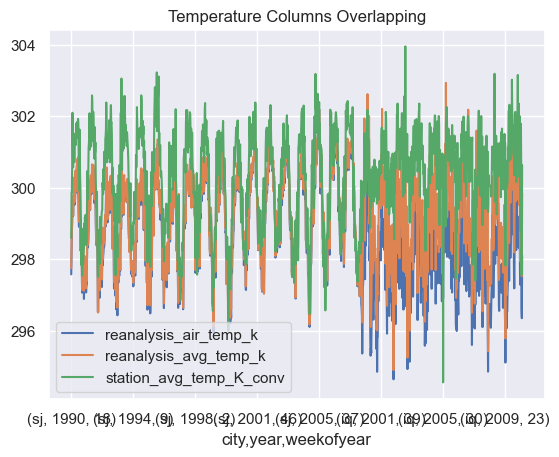

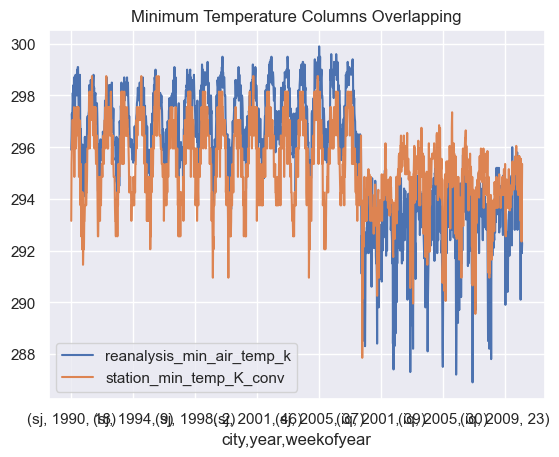

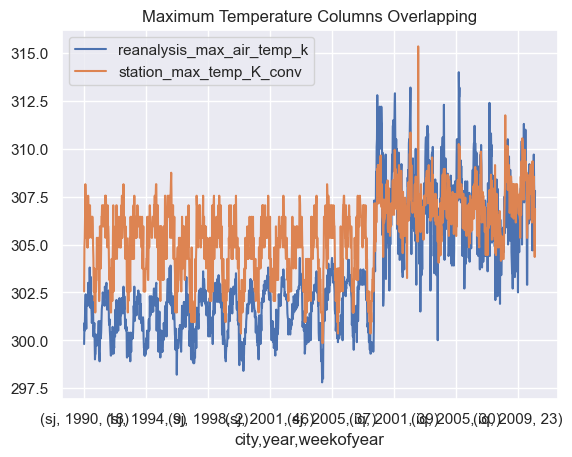

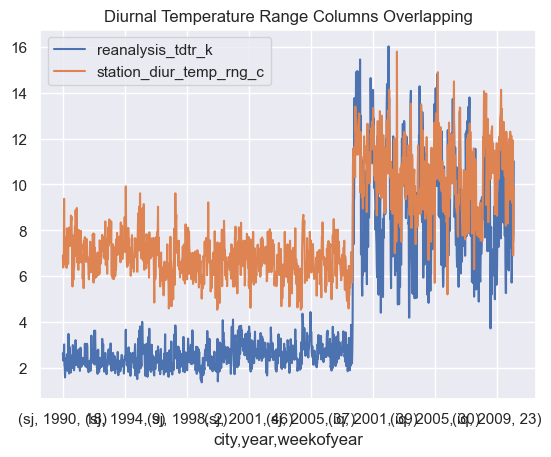

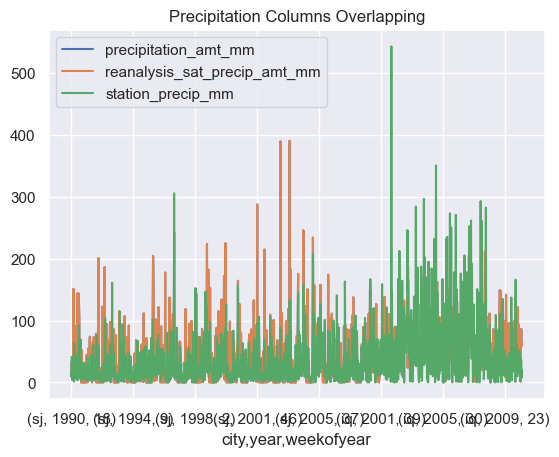

In [127]:
train_features[air_temp].plot(title='Temperature Columns Overlapping', legend=True)
plt.show()

train_features[min_temp].plot(title='Minimum Temperature Columns Overlapping', legend=True)
plt.show()

train_features[max_temp].plot(title='Maximum Temperature Columns Overlapping', legend=True)
plt.show()

train_features[diurn_rg_temp].plot(title='Diurnal Temperature Range Columns Overlapping', legend=True)
plt.show()

train_features[precip_amt].plot(title='Precipitation Columns Overlapping', legend=True)
plt.show()

There seems to be a noticeable difference between the 'reanalysis' temperature values and the 'station' temperature values.  There is currently no basis on which to choose one or the other, so the choice is entirely random at this point, until this work can be revisited for a better selection method.  The 'reanalysis' temperature values will be kept.  Similarly, the 'reanalysis' precipitation will be kept for consistency.

Similarly, for now, the 'reanalysis' precipitation in kg/m2 will be kept as it is a different way to measure precipitation as compared to mm.

# !The same columns will have to be dropped from the dengue_features_test dataset  

The model won't know what to do with extraneous features.

In [136]:
# identify the 'redundant' features, and their converted versions, for removal.  Add to this list the time interval variable created earlier for 
# the time step investigation.

redundant_features = (['station_avg_temp_c', 'station_avg_temp_K_conv', 'station_max_temp_c', 'station_max_temp_K_conv',
                       'station_min_temp_c', 'station_min_temp_K_conv', 'precipitation_amt_mm', 'station_precip_mm', 
                       'time_interval','station_diur_temp_rng_c'])

for r_feature in redundant_features:
    train_features.drop(r_feature, axis=1, inplace=True)

In [138]:
train_features.head()

week_start_date   ndvi_ne   ndvi_nw   ndvi_se   ndvi_sw  \
city year weekofyear                                                           
sj   1990 18              1990-04-30  0.122600  0.103725  0.198483  0.177617   
          19              1990-05-07  0.169900  0.142175  0.162357  0.155486   
          20              1990-05-14  0.032250  0.172967  0.157200  0.170843   
          21              1990-05-21  0.128633  0.245067  0.227557  0.235886   
          22              1990-05-28  0.196200  0.262200  0.251200  0.247340   

                      reanalysis_air_temp_k  reanalysis_avg_temp_k  \
city year weekofyear                                                 
sj   1990 18                     297.572857             297.742857   
          19                     298.211429             298.442857   
          20                     298.781429             298.878571   
          21                     298.987143             299.228571   
          22                     299.518571             299.664286   

                      reanalysis_dew_point_temp_k  reanalysis_max_air_temp_k  \
city year weekofyear                                                           
sj   1990 18                           292.414286                      299.8   
          19                           293.951429                      300.9   
          20                           295.434286                      300.5   
          21                           295.310000                      301.4   
          22                           295.821429                      301.9   

                      reanalysis_min_air_temp_k  \
city year weekofyear                              
sj   1990 18                              295.9   
          19                              296.4   
          20                              297.3   
          21                              297.0   
          22                              297.5   

                      reanalysis_precip_amt_kg_per_m2  \
city year weekofyear                                    
sj   1990 18                                    32.00   
          19                                    17.94   
          20                                    26.10   
          21                                    13.90   
          22                                    12.20   

                      reanalysis_relative_humidity_percent  \
city year weekofyear                                         
sj   1990 18                                     73.365714   
          19                                     77.368571   
          20                                     82.052857   
          21                                     80.337143   
          22                                     80.460000   

                      reanalysis_sat_precip_amt_mm  \
city year weekofyear                                 
sj   1990 18                                 12.42   
          19                                 22.82   
          20                                 34.54   
          21                                 15.36   
          22                                  7.52   

                      reanalysis_specific_humidity_g_per_kg  reanalysis_tdtr_k  
city year weekofyear                                                            
sj   1990 18                                      14.012857           2.628571  
          19                                      15.372857           2.371429  
          20                                      16.848571           2.300000  
          21                                      16.672857           2.428571  
          22                                      17.210000           3.014286

In [139]:
train_features.describe()

,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k
count,1456,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000
mean,2001-07-09 16:01:19.120879104,0.131271,0.128068,0.202606,0.201987,298.697965,299.221483,295.245445,303.419505,295.719712,40.111635,82.176203,45.686937,16.745565,4.898656
min,1990-04-30 00:00:00,-0.406250,-0.456100,-0.015533,-0.063457,294.635714,294.892857,289.642857,297.800000,286.900000,0.000000,57.787143,0.000000,11.715714,1.357143
25%,1997-04-28 06:00:00,0.039100,0.048250,0.152795,0.144455,297.654643,298.257143,294.119643,301.000000,293.900000,13.085000,77.185714,9.655000,15.560000,2.328571
50%,2002-05-28 00:00:00,0.113900,0.115926,0.195664,0.190121,298.646429,299.285714,295.639286,302.400000,296.200000,27.245000,80.301429,38.235000,17.087143,2.857143
75%,2005-11-26 00:00:00,0.232018,0.213429,0.247461,0.246775,299.827500,300.207143,296.460000,305.500000,297.900000,52.200000,86.406429,70.227500,17.977500,7.617857
max,2010-06-25 00:00:00,0.508357,0.454429,0.538314,0.546017,302.200000,302.928571,298.450000,314.000000,299.900000,570.500000,98.610000,390.600000,20.461429,16.028571
std,NaN,0.138527,0.119561,0.074409,0.083592,1.361950,1.262676,1.527527,3.233030,2.559398,43.329174,7.161016,43.779318,1.542276,3.542340


A case could be made for dropping either reanalysis_air_temp_k or reanalysis_avg_temp_k as their statistics are very similar.  They'll be left in for now.  

### Separating the Data by City
Time to separate the data for the two cities.

In [47]:
# Seperate data for San Juan
sj_train_features = train_features.loc['sj']
sj_train_labels = train_labels.loc['sj']

# Separate data for Iquitos
iq_train_features = train_features.loc['iq']
iq_train_labels = train_labels.loc['iq']

## Data Distribution  

Below we'll get a sense of the mean and variance on the dengue cases for each city.  Of course we fully anticipate there's some seasonality to this, so the statistics have to be taken with a grain of salt.

In [ ]:
print('San Juan')
print('mean: ', sj_train_labels.mean()[0])
print('var :', sj_train_labels.var()[0])

print('\nIquitos')
print('mean: ', iq_train_labels.mean()[0])
print('var :', iq_train_labels.var()[0])

San Juan
mean:  34.18055555555556
var : 2640.0454396910277

Iquitos
mean:  7.565384615384615
var : 115.89552393656439


Basic timeseries plots show clear spikes in case counts

# See the supervised learning notebook to produce many plots in one window.  
Loop through the features left (now that some have been dropped) for each city.

Text(0.5, 0, 'Time')

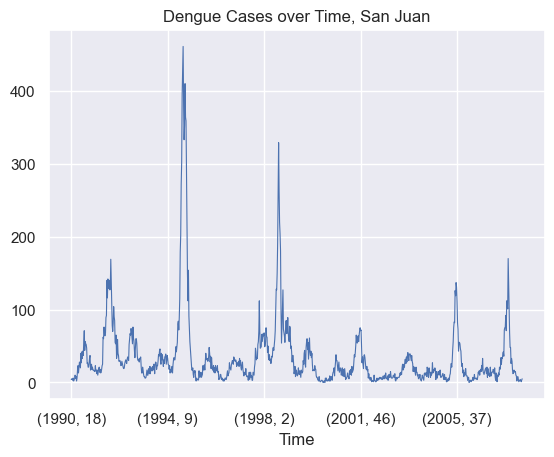

In [62]:
(sj_train_labels
     .total_cases
     .plot
     .line(lw=0.8))

plt.title('Dengue Cases over Time, San Juan')
plt.xlabel('Time')

Text(0.5, 0, 'Time')

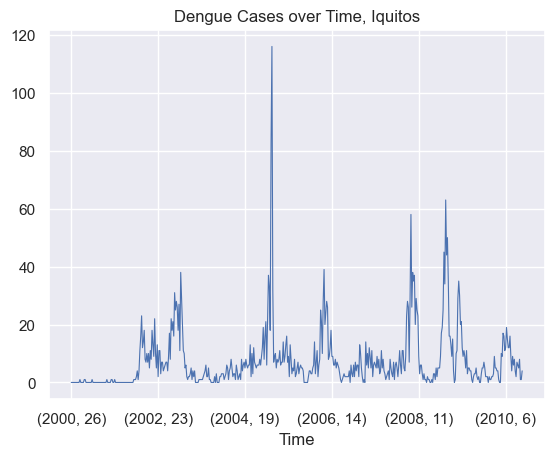

In [63]:
(iq_train_labels
     .total_cases
     .plot
     .line(lw=0.8))

plt.title('Dengue Cases over Time, Iquitos')
plt.xlabel('Time')

Timeseries plots by feature per city go here.  
We'll need autocorrelations on cases, and the ACF plot.  Presumably helps us pick a y lag.  
Question is, how to pick a lag between y and each feature?  Or do you start "dummy" and just pick the same lag as for y?
Could produce lagged correlation plots between y(t) and each feature (t-lag)